# Package Import

In [78]:
from ucimlrepo import fetch_ucirepo 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from autosklearn.classification import AutoSklearnClassifier
import optuna

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data import and Split

In [2]:
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets 

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y.to_numpy().ravel(),
    test_size=0.25,
    stratify=y,
    random_state=42
)

# AutoML

In [4]:
automl = AutoSklearnClassifier(
    time_left_for_this_task=120,
)

In [5]:
automl.fit(X_train, y_train)

AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      per_run_time_limit=12, time_left_for_this_task=120)

In [6]:
automl.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
2,1,0.46,random_forest,0.229224,2.962476
3,2,0.06,random_forest,0.243836,3.560432
7,3,0.06,gradient_boosting,0.249315,7.621041
6,4,0.24,passive_aggressive,0.263927,0.799533
11,5,0.08,random_forest,0.264840,2.749202
12,6,0.10,mlp,0.295890,7.538225


In [7]:
y_pred_ensemble = automl.predict(X_test)

In [8]:
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print("Auto-Sklearn Ensemble Accuracy:", ensemble_accuracy)

Auto-Sklearn Ensemble Accuracy: 0.7585895117540687


# Bayesian Optimization

In [9]:
col_ohe = [
    'Marital Status',
    'Application mode',
    'Course',
    'Previous qualification',
    'Nacionality',
    "Mother's qualification",
    "Father's qualification",
    "Mother's occupation",
    "Father's occupation",
]

columntransfomer = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'), col_ohe),
    ], 
    remainder='passthrough'
)

In [10]:
X_train_prep = columntransfomer.fit_transform(X_train)
X_train_prep

array([[ 1.  ,  0.  ,  0.  , ..., 15.5 ,  2.8 , -4.06],
       [ 1.  ,  0.  ,  0.  , ..., 12.4 ,  0.5 ,  1.79],
       [ 1.  ,  0.  ,  0.  , ..., 11.1 ,  0.6 ,  2.02],
       ...,
       [ 1.  ,  0.  ,  0.  , ..., 12.7 ,  3.7 , -1.7 ],
       [ 1.  ,  0.  ,  0.  , ...,  8.9 ,  1.4 ,  3.51],
       [ 1.  ,  0.  ,  0.  , ...,  7.6 ,  2.6 ,  0.32]])

In [11]:
X_test_prep = columntransfomer.transform(X_test)
X_test_prep

array([[ 1.  ,  0.  ,  0.  , ...,  9.4 , -0.8 , -3.12],
       [ 1.  ,  0.  ,  0.  , ..., 10.8 ,  1.4 ,  1.74],
       [ 1.  ,  0.  ,  0.  , ..., 11.1 ,  0.6 ,  2.02],
       ...,
       [ 1.  ,  0.  ,  0.  , ..., 12.7 ,  3.7 , -1.7 ],
       [ 1.  ,  0.  ,  0.  , ...,  9.4 , -0.8 , -3.12],
       [ 1.  ,  0.  ,  0.  , ..., 13.9 , -0.3 ,  0.79]])

In [15]:
def objective(trial):
    # Define the hyperparameter search space
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]), 
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
    }

    # Initialize the model with current hyperparameters
    model = RandomForestClassifier(**param, random_state=42)

    # Train the model
    model.fit(X_train_prep, y_train)

    # Evaluate the model
    preds = model.predict(X_test_prep)
    accuracy = accuracy_score(y_test, preds)

    return accuracy

In [16]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-11-28 04:21:16,572] A new study created in memory with name: no-name-d7af1f3e-b33b-44e4-90b2-0cf6bcc091e5
[I 2024-11-28 04:21:17,218] Trial 0 finished with value: 0.7377938517179023 and parameters: {'n_estimators': 227, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'gini', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7377938517179023.
[I 2024-11-28 04:21:23,784] Trial 1 finished with value: 0.7251356238698011 and parameters: {'n_estimators': 379, 'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': False, 'criterion': 'entropy', 'class_weight': None}. Best is trial 0 with value: 0.7377938517179023.
[I 2024-11-28 04:21:34,413] Trial 2 finished with value: 0.6600361663652803 and parameters: {'n_estimators': 302, 'max_depth': 19, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': False, 'criterion': 'entropy', 'class_we

[I 2024-11-28 04:22:50,499] Trial 26 finished with value: 0.7613019891500904 and parameters: {'n_estimators': 174, 'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 20, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy', 'class_weight': None}. Best is trial 23 with value: 0.7721518987341772.
[I 2024-11-28 04:22:52,183] Trial 27 finished with value: 0.7658227848101266 and parameters: {'n_estimators': 92, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'class_weight': None}. Best is trial 23 with value: 0.7721518987341772.
[I 2024-11-28 04:22:52,484] Trial 28 finished with value: 0.7142857142857143 and parameters: {'n_estimators': 134, 'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 18, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini', 'class_weight': None}. Best is trial 23 with value: 0.7721518987341772.
[I 2024-11-28 04:22:53,130] Trial 29 finished with 

In [17]:
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

Best hyperparameters: {'n_estimators': 109, 'max_depth': 15, 'min_samples_split': 14, 'min_samples_leaf': 20, 'max_features': None, 'bootstrap': True, 'criterion': 'gini', 'class_weight': None}
Best accuracy: 0.7721518987341772


In [19]:
best_params = study.best_params
opt = RandomForestClassifier(**best_params, random_state=42)
opt.fit(X_train_prep, y_train)

final_accuracy = accuracy_score(y_test, opt.predict(X_test_prep))
print("Final accuracy with optimized GradientBoostingClassifier:", final_accuracy)

Final accuracy with optimized GradientBoostingClassifier: 0.7721518987341772


# Inference Time

In [20]:
import time

# Measure inference time for Auto-Sklearn ensemble
start_time = time.time()
automl.predict(X_test)
ensemble_inference_time = time.time() - start_time
print("Auto-Sklearn Ensemble Inference Time:", ensemble_inference_time)

# Measure inference time for the optimized model
start_time = time.time()
opt.predict(X_test_prep)
optimized_inference_time = time.time() - start_time
print("Optimized Model Inference Time:", optimized_inference_time)

Auto-Sklearn Ensemble Inference Time: 0.39054441452026367
Optimized Model Inference Time: 0.021266460418701172


# Permutation Importance

In [21]:
# Permutation importance for Auto-Sklearn ensemble
ensemble_importances = permutation_importance(automl, X_test, y_test, n_repeats=10, random_state=42)
print("Ensemble Feature Importances:", ensemble_importances.importances_mean)

# Permutation importance for optimized model
optimized_importances = permutation_importance(opt, X_test_prep, y_test, n_repeats=10, random_state=42)
print("Optimized Model Feature Importances:", optimized_importances.importances_mean)

Ensemble Feature Importances: [-2.98372514e-03 -2.53164557e-03 -5.42495479e-04  2.26039783e-03
 -9.04159132e-05  3.88788427e-03  2.26039783e-03 -5.42495479e-04
 -3.25497288e-03 -5.15370705e-03 -3.52622061e-03 -1.98915009e-03
 -3.07414105e-03 -4.52079566e-03 -1.08499096e-03  3.07414105e-03
  4.12296564e-02 -4.24954792e-03 -1.08499096e-03  4.97287523e-03
  0.00000000e+00 -2.71247740e-04  1.26582278e-03  1.62748644e-03
  4.23146474e-02 -3.70705244e-03  1.35623870e-03  9.04159132e-05
  5.78661844e-03 -5.78661844e-03  1.73688969e-01  1.36528029e-02
 -9.94575045e-04 -3.34538879e-03  2.53164557e-03 -9.04159132e-04]
Optimized Model Feature Importances: [ 0.00000000e+00  9.04159132e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.98372514e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.16998192e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.71247740e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00

In [22]:
ensemble_importances.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

<BarContainer object of 36 artists>

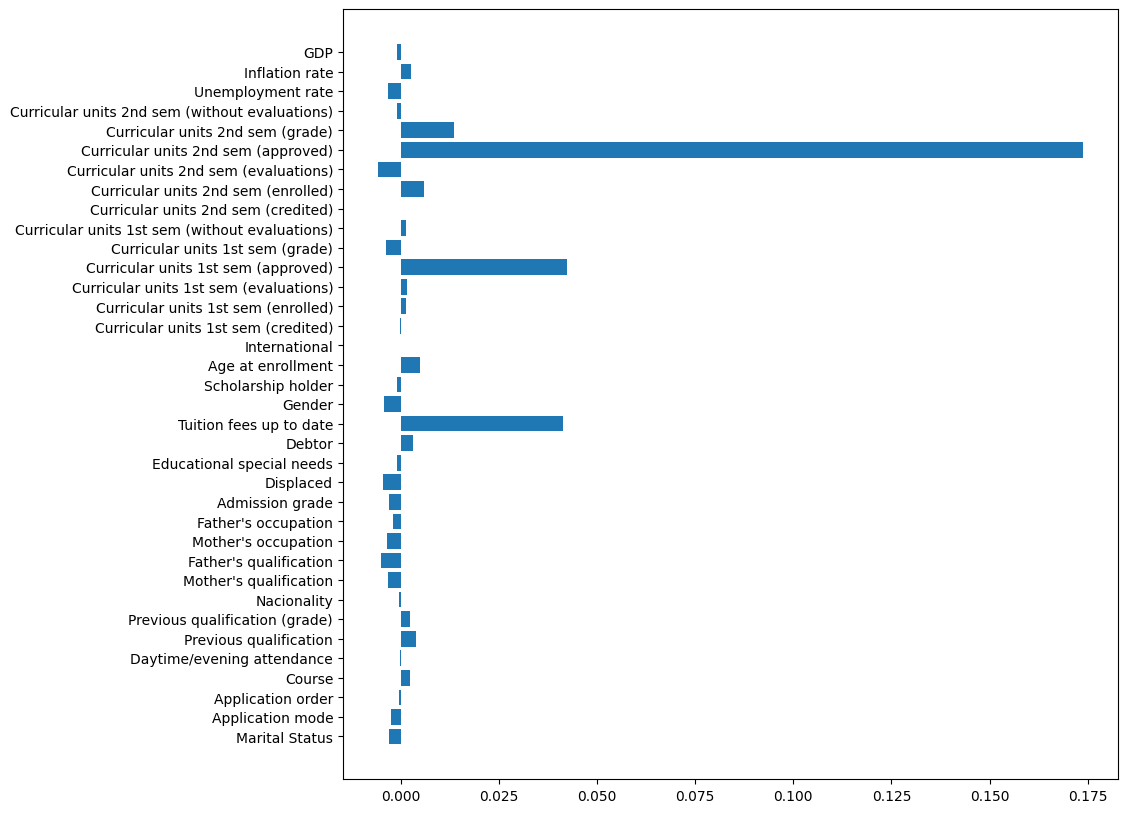

In [61]:
im = ensemble_importances.importances_mean
plt.figure(figsize=(10, 10))
plt.barh(X_train.columns, im)

In [64]:
top_indices = np.argsort(np.abs(im))[-10:][::-1]
top_feature_importance = im[top_indices]
top_feature = np.array(X_train.columns)[top_indices]
top_features_auto_df = pd.DataFrame({'AutoML Feature': top_feature, 'AutoML importance': top_feature_importance})
top_features_auto_df

,AutoML Feature,AutoML importance
0,Curricular units 2nd sem (approved),0.173689
1,Curricular units 1st sem (approved),0.042315
2,Tuition fees up to date,0.041230
3,Curricular units 2nd sem (grade),0.013653
4,Curricular units 2nd sem (enrolled),0.005787
5,Curricular units 2nd sem (evaluations),-0.005787
6,Father's qualification,-0.005154
7,Age at enrollment,0.004973
8,Displaced,-0.004521
9,Gender,-0.004250


<BarContainer object of 231 artists>

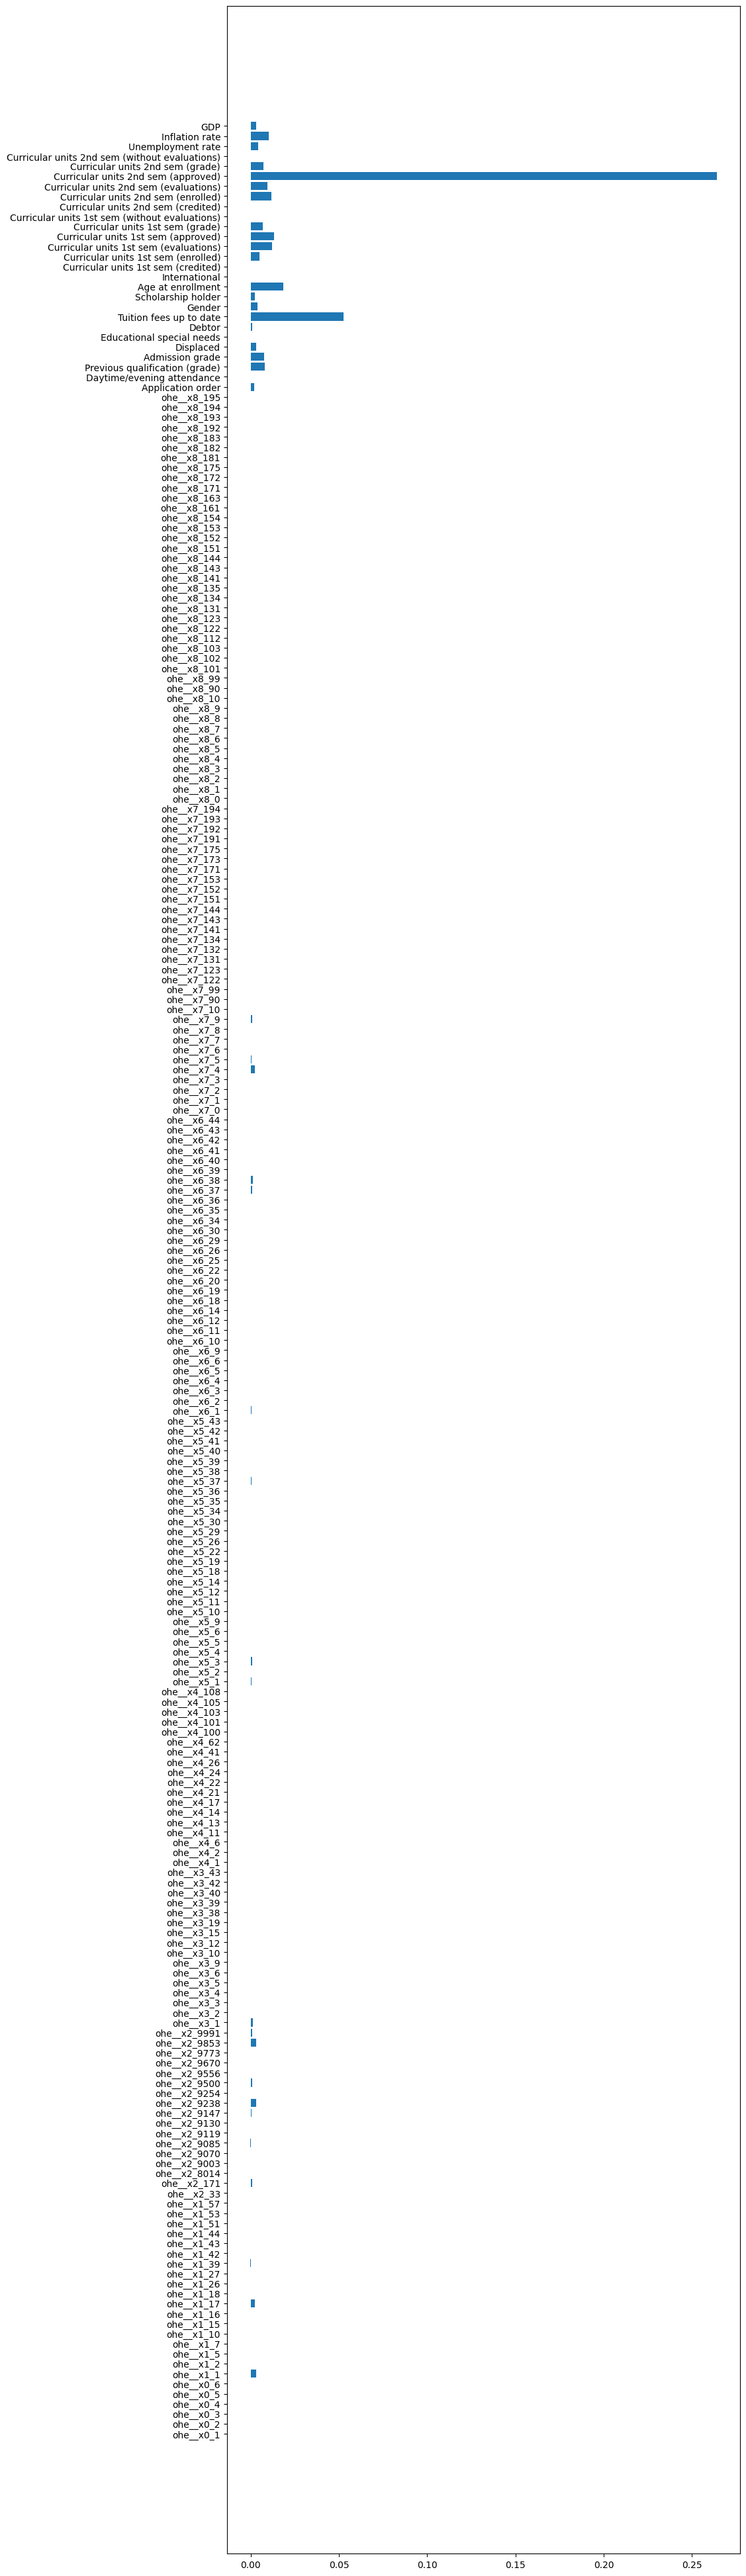

In [24]:
im2 = optimized_importances.importances_mean
plt.figure(figsize=(10, 50))
plt.barh(columntransfomer.get_feature_names(), im2)

In [68]:
top_indices = np.argsort(np.abs(im2))[-10:][::-1]
top_feature_importance = im2[top_indices]
top_feature = np.array(columntransfomer.get_feature_names())[top_indices]
top_features_opti_df = pd.DataFrame({'BayesianOpti Feature': top_feature, 'BayesianOpti Importance': top_feature_importance})
top_features_opti_df

,BayesianOpti Feature,BayesianOpti Importance
0,Curricular units 2nd sem (approved),0.263924
1,Tuition fees up to date,0.052622
2,Age at enrollment,0.018354
3,Curricular units 1st sem (approved),0.013110
4,Curricular units 1st sem (evaluations),0.012025
5,Curricular units 2nd sem (enrolled),0.011844
6,Inflation rate,0.010217
7,Curricular units 2nd sem (evaluations),0.009403
8,Previous qualification (grade),0.007866
9,Admission grade,0.007414


# Summary

## Accuracy and Inference Time

In [29]:
pd.DataFrame(
    {
        'AutoML':[ensemble_accuracy, ensemble_inference_time],
        'BayesianOpti':[final_accuracy, optimized_inference_time]
    },
    index=['Accuracy', 'Inference Time']
)

,AutoML,BayesianOpti
Accuracy,0.758590,0.772152
Inference Time,0.390544,0.021266


## Top 10 Feature based on Permutation Importance

In [69]:
pd.concat([top_features_auto_df, top_features_opti_df], axis=1)

,AutoML Feature,AutoML importance,BayesianOpti Feature,BayesianOpti Importance
0,Curricular units 2nd sem (approved),0.173689,Curricular units 2nd sem (approved),0.263924
1,Curricular units 1st sem (approved),0.042315,Tuition fees up to date,0.052622
2,Tuition fees up to date,0.041230,Age at enrollment,0.018354
3,Curricular units 2nd sem (grade),0.013653,Curricular units 1st sem (approved),0.013110
4,Curricular units 2nd sem (enrolled),0.005787,Curricular units 1st sem (evaluations),0.012025
5,Curricular units 2nd sem (evaluations),-0.005787,Curricular units 2nd sem (enrolled),0.011844
6,Father's qualification,-0.005154,Inflation rate,0.010217
7,Age at enrollment,0.004973,Curricular units 2nd sem (evaluations),0.009403
8,Displaced,-0.004521,Previous qualification (grade),0.007866
9,Gender,-0.004250,Admission grade,0.007414


## Confusion Matrices

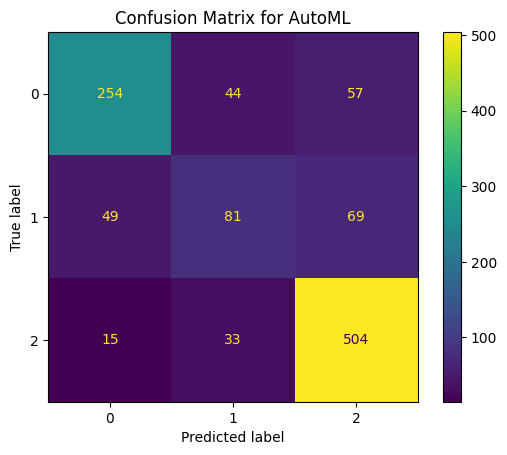

In [82]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_ensemble)).plot()
plt.title('Confusion Matrix for AutoML');

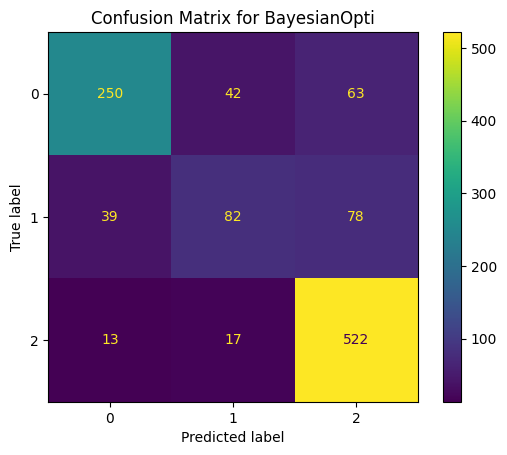

In [83]:
ConfusionMatrixDisplay(confusion_matrix(y_test, opt.predict(X_test_prep))).plot()
plt.title('Confusion Matrix for BayesianOpti');

From the summary, it is observed that the model with Bayesian optimization (using Optuna) has a higher accuracy for the test data and has less inference time when compared to the model generated using AutoML (using Auto-Sklearn).

Upon checking the top10 features that has the highest feature importance (based from permutation_importance), the feature "Curricular units 2nd sem (approved)" is both the strongest identifier if the student will Dropout, Graduate, or Enroll.